In [2]:
import os
import sys
import subprocess
import time
import traci
import numpy as np
import random

# --- CONFIGURATION ---
SUMO_FOLDER = "sumo_configs"

# Création du dossier si inexistant
if not os.path.exists(SUMO_FOLDER):
    os.makedirs(SUMO_FOLDER)

# Configuration automatique du chemin SUMO (Windows)
if "SUMO_HOME" not in os.environ:
    os.environ["SUMO_HOME"] = r"C:\Program Files (x86)\Eclipse\Sumo"

sumo_bin = os.path.join(os.environ["SUMO_HOME"], "bin")
if sumo_bin not in os.environ["PATH"]:
    os.environ["PATH"] += os.pathsep + sumo_bin

# Ajout des outils SUMO au path Python
sys.path.append(os.path.join(os.environ["SUMO_HOME"], "tools"))

print(f"✅ Environnement configuré. SUMO_HOME: {os.environ['SUMO_HOME']}")

✅ Environnement configuré. SUMO_HOME: C:\Program Files (x86)\Eclipse\Sumo\


In [3]:
# --- CELLULE 2 : GÉNÉRATION DU RÉSEAU COMPLEXE ---
import os
import subprocess

# 1. Noeuds (Nodes)
nodes_xml = """<nodes>
    <node id="C" x="0" y="0" type="traffic_light"/>
    <node id="N" x="0" y="100"/> <node id="S" x="0" y="-100"/>
    <node id="E" x="100" y="0"/> <node id="W" x="-100" y="0"/>
</nodes>"""

# 2. Routes (Edges) avec Trottoirs (sidewalkWidth)
edges_xml = """<edges>
    <edge id="N2C" from="N" to="C" priority="1" numLanes="2" speed="13.89" sidewalkWidth="2.0"/>
    <edge id="C2S" from="C" to="S" priority="1" numLanes="2" speed="13.89" sidewalkWidth="2.0"/>
    <edge id="E2C" from="E" to="C" priority="1" numLanes="2" speed="13.89" sidewalkWidth="2.0"/>
    <edge id="C2W" from="C" to="W" priority="1" numLanes="2" speed="13.89" sidewalkWidth="2.0"/>
</edges>"""

# 3. Scénario (Routes, Piétons, Ambulance)
routes_xml = """<routes>
    <vType id="car" accel="1.0" decel="4.5" length="5" maxSpeed="15.0" guiShape="passenger"/>
    <vType id="emergency" accel="3.0" decel="5.0" length="5" maxSpeed="25.0" guiShape="emergency" color="red"/>
    <vType id="pedestrian" vClass="pedestrian" color="yellow" guiShape="person"/>

    <flow id="fN" type="car" begin="0" end="3600" probability="0.2" from="N2C" to="C2S"/>
    <flow id="fE" type="car" begin="0" end="3600" probability="0.1" from="E2C" to="C2W"/>

    <personFlow id="p1" begin="0" end="3600" probability="0.05">
        <walk from="N2C" to="C2S"/>
    </personFlow>

    <vehicle id="amb_1" type="emergency" depart="200" departLane="1">
        <route edges="E2C C2W"/>
    </vehicle>
</routes>"""

# 4. Configuration
config_xml = """<configuration>
    <input><net-file value="network.net.xml"/><route-files value="routes.rou.xml"/></input>
    <time><begin value="0"/><end value="2000"/></time>
</configuration>"""

# Sauvegarde et Compilation
files = {"nodes.nod.xml": nodes_xml, "edges.edg.xml": edges_xml, "routes.rou.xml": routes_xml, "config.sumocfg": config_xml}
for name, content in files.items():
    with open(os.path.join(SUMO_FOLDER, name), "w") as f: f.write(content)

print("⏳ Compilation avec passages piétons...")
# --crossings.guess permet de créer les passages piétons automatiquement
subprocess.run(["netconvert", "--node-files", os.path.join(SUMO_FOLDER, "nodes.nod.xml"),
                "--edge-files", os.path.join(SUMO_FOLDER, "edges.edg.xml"),
                "--crossings.guess", "true",
                "-o", os.path.join(SUMO_FOLDER, "network.net.xml")], shell=True, stdout=subprocess.DEVNULL)
print("✅ Réseau avec trottoirs et urgences prêt.")

⏳ Compilation avec passages piétons...
✅ Réseau avec trottoirs et urgences prêt.


In [4]:
class TrafficAgent:
    def __init__(self):
        self.q_table = {} # La mémoire de l'IA (Tableau Q)
        self.alpha = 0.1  # Taux d'apprentissage (Learning Rate)
        self.gamma = 0.9  # Importance du futur (Discount Factor)
        self.epsilon = 0.2 # Taux d'exploration (20% du temps, on teste au hasard)
        
    def get_state(self, density_N, density_E):
        """
        TÂCHE 2 : CLASSIFICATION ML
        Transforme le nombre exact de voitures en une catégorie (État).
        0=Vide, 1=Faible, 2=Moyen, 3=Elevé
        """
        def classify(n):
            if n == 0: return 0
            if n < 3: return 1
            if n < 6: return 2
            return 3
            
        # L'état est un couple (Etat_Nord, Etat_Est), ex: (3, 1)
        return (classify(density_N), classify(density_E))

    def choose_action(self, state):
        """Choisit de mettre le feu Vert au Nord (0) ou à l'Est (1)"""
        
        # Initialisation de l'état s'il est inconnu
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0] # [Valeur Nord, Valeur Est]

        # Stratégie Epsilon-Greedy
        if random.uniform(0, 1) < self.epsilon:
            return random.choice([0, 1]) # Exploration : Hasard
        else:
            return np.argmax(self.q_table[state]) # Exploitation : Meilleure action connue

    def learn(self, state, action, reward, next_state):
        """Mise à jour de la Q-Table via l'équation de Bellman"""
        if next_state not in self.q_table:
            self.q_table[next_state] = [0.0, 0.0]
            
        old_value = self.q_table[state][action]
        next_max = np.max(self.q_table[next_state])
        
        # Formule Q-Learning
        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state][action] = new_value

In [5]:
def simulate_yolo_detection():
    """
    TÂCHE 1 : DÉTECTION
    Récupère le nombre de véhicules à l'arrêt via SUMO 
    pour simuler une détection par caméra.
    """
    # On récupère le nombre de voitures arrêtées sur les voies entrantes
    n_cars = traci.edge.getLastStepHaltingNumber("N2C")
    e_cars = traci.edge.getLastStepHaltingNumber("E2C")
    return int(n_cars), int(e_cars)

🚀 Démarrage Simulation (IA + Anti-Blocage)...
 Retrying in 1 seconds
Step: 1000 | N=2 vs E=0 | Mode: 🤖 IA (Optimisation) | Action: Vert NORD ↕️   
✅ Simulation terminée.


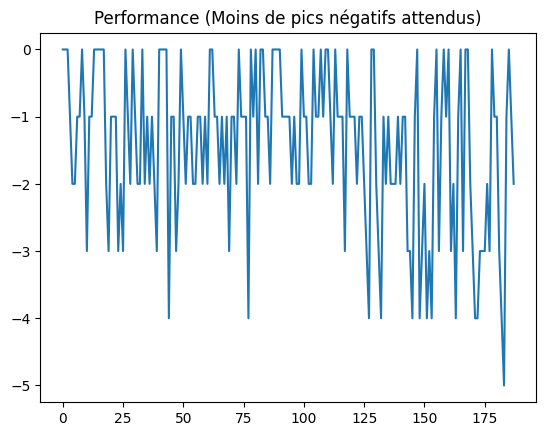

In [6]:
# --- CELLULE 5 : SIMULATION HYBRIDE + ANTI-BLOCAGE ---
import time
import sys
import os
import traci
import sumolib
import random
import numpy as np
import matplotlib.pyplot as plt

# Nettoyage
os.system("taskkill /f /im sumo-gui.exe >nul 2>&1")
time.sleep(1)

agent = TrafficAgent()
history_rewards = []

try:
    print("🚀 Démarrage Simulation (IA + Anti-Blocage)...")
    port = sumolib.miscutils.getFreeSocketPort()
    traci.start(["sumo-gui", "-c", os.path.join(SUMO_FOLDER, "config.sumocfg"), "--start"], port=port)
    
    TL_ID = "C"
    last_state = (0, 0)
    last_action = 0
    step = 0
    
    # Seuil critique : Si une voie a X voitures de plus que l'autre, on force le vert
    SEUIL_CRITIQUE = 4 
    
    while step < 1000:
        time.sleep(0.05) 
        for _ in range(5): 
            traci.simulationStep()
            step += 1

        # 1. PERCEPTION
        # Urgences
        vehs_N = traci.edge.getLastStepVehicleIDs("N2C")
        vehs_E = traci.edge.getLastStepVehicleIDs("E2C")
        urgence_N = any(traci.vehicle.getTypeID(v) == "emergency" for v in vehs_N)
        urgence_E = any(traci.vehicle.getTypeID(v) == "emergency" for v in vehs_E)
        
        # Densité
        qN, qE = simulate_yolo_detection()
        
        # 2. LOGIQUE DE DÉCISION (HIERARCHIE STRICTE)
        
        # A. PRIORITÉ ABSOLUE : AMBULANCE
        if urgence_N:
            action = 0 # Force NORD
            mode = "🚨 URGENCE NORD"
        elif urgence_E:
            action = 1 # Force EST
            mode = "🚨 URGENCE EST"
            
        # B. PRIORITÉ SECONDAIRE : ANTI-BLOCAGE (Votre demande)
        # Si l'Est est bouché et le Nord est vide (ou presque), on FORCE l'Est
        elif qE > qN + SEUIL_CRITIQUE:
            action = 1 # Force EST
            mode = "⚠️ ANTI-BLOCAGE EST"
            
        # Si le Nord est bouché et l'Est est vide
        elif qN > qE + SEUIL_CRITIQUE:
            action = 0 # Force NORD
            mode = "⚠️ ANTI-BLOCAGE NORD"

        # C. TRAFIC NORMAL : L'IA OPTIMISE LE FLUX
        else:
            current_state = agent.get_state(qN, qE)
            reward = - (qN + qE)
            
            agent.learn(last_state, last_action, reward, current_state)
            action = agent.choose_action(current_state)
            
            last_state = current_state
            last_action = action
            history_rewards.append(reward)
            mode = "🤖 IA (Optimisation)"

        # 3. APPLICATION
        phase_sumo = 0 if action == 0 else 2
        traci.trafficlight.setPhase(TL_ID, phase_sumo)

        # Affichage plus clair
        direction = "Vert NORD ↕️" if action == 0 else "Vert EST ↔️"
        sys.stdout.write(f"\rStep: {step} | N={qN} vs E={qE} | Mode: {mode} | Action: {direction}   ")
        sys.stdout.flush()

    print("\n✅ Simulation terminée.")
    traci.close()
    
    plt.plot(history_rewards)
    plt.title("Performance (Moins de pics négatifs attendus)")
    plt.show()

except Exception as e:
    print(f"\n❌ Erreur : {e}")
    try: traci.close()
    except: pass